# Jiang dataset analysis
## Filtering, frequency drawing, etc.

In [2]:
%load_ext autoreload
%autoreload 2

In [64]:
from torchtext.data import Dataset, Field
from datasets.CommitMessageGenerationDataset import CommitMessageGenerationDataset
from datasets.CodeChangesDataset import CodeChangesTokensDataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [31]:
def plot_lengths_distribution(data):
    data_lengths =  {k: [len(example.src) for example in v] for k, v in data.items()}
    for data_type, lengths in data_lengths.items():        
        plt.hist(lengths, bins=101)
        plt.title(f'Lengths on {data_type}')
        plt.show()

In [36]:
def load_dataset(dataset_path: str):
    config = {
        'TOKEN_MIN_FREQ': 1,
        'TOKENS_CODE_CHUNK_MAX_LEN': 100,
        'MSG_MAX_LEN': 30,
        'DATASET_ROOT': dataset_path,
        'DATASET_ROOT_COMMIT': dataset_path,
        'LOWER': False,
        'LOWER_COMMIT_MSG': True,
        'UNK_TOKEN': "<unk>",
        'PAD_TOKEN': "<pad>",
        'SOS_TOKEN': "<s>",
        'EOS_TOKEN': "</s>",
        'REPLACEMENT_TOKEN': 'замена',
        'DELETION_TOKEN': 'удаление',
        'ADDITION_TOKEN': 'добавление',
        'UNCHANGED_TOKEN': 'равенство',
        'PADDING_TOKEN': 'паддинг',
        'LEAVE_ONLY_CHANGED': True,
    }
    train_dataset, val_dataset, test_dataset, diffs_field = \
        CodeChangesTokensDataset.load_data(False, config)
    train_dataset_commit, val_dataset_commit, test_dataset_commit, fields_commit = \
        CommitMessageGenerationDataset.load_data(diffs_field, True, config)
    data = {'train': train_dataset_commit, 'validation': val_dataset_commit, 'test': test_dataset_commit}
    return data

In [332]:
ORIGINAL_JIANG_DATASET_PATH = '../embeddings-for-code-diffs-data/datasets/commit_message_generation/Jiang/full'
ORIGINAL_JIANG_DATA = load_dataset(ORIGINAL_JIANG_DATASET_PATH)
ORIGINAL_JIANG_DATA_SRC_VOCAB = ORIGINAL_JIANG_DATA['train'].fields["src"].vocab
ORIGINAL_JIANG_DATA_TRG_VOCAB = ORIGINAL_JIANG_DATA['train'].fields["trg"].vocab

Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 104 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has len

Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 105 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 103 > 100
Incorrect example is seen. Error: 0th element of example has length 105 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 104 > 100
Incorrect example is seen. Error: 0th element of example has length 108 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has len

Data set sizes (number of sentence pairs):
train 26112
valid 2989
test 2989 

Max src sequence length in tokens: 100
Max trg sequence length in tokens: 30
Max diff sequence length in tokens: 84 

First training example:
src: new file mode 100755 <nl> index 0000000 . . d125c52 <nl> Binary files / dev / null and b / art / intro . png differ <nl>
trg: added intro image .
diff_alignment: удаление удаление удаление удаление удаление
diff_prev: new file mode 100755 <nl>
diff_updated: паддинг паддинг паддинг паддинг паддинг
Most common words in src vocabulary:
         /     227054
      <nl>     216283
         .     126518
         -      77621
         =      46594
         +      33946
         b      25643
         a      25399
         :      22856
       mmm      22094 


Most common words in trg vocabulary:
         .      14008
         /      13641
         -       7514
        to       5472
    update       4482
         '       4441
    ignore       3873
   modules       3333
    

In [350]:
def print_general_information(data):
    print(f'src vocabulary size: {len(data["train"].fields["src"].vocab)}')
    print(f'trg vocabulary size: {len(data["train"].fields["trg"].vocab)}')

In [446]:
def plot_frequency_dist(src_vocab, trg_vocab):
    def take_boundary(boundary):
        mask = np.logical_and(frequencies >= boundary[0], frequencies < boundary[1])
        return frequencies[mask]
    
    def get_mass_of_frequencies(boundary):
        boundaried_frequencies = take_boundary(boundary)
        return len(boundaried_frequencies) / len(frequencies)
    
    def get_mass_of_tokens(boundary):
        boundaried_frequencies = take_boundary(boundary)
        return boundaried_frequencies.sum() / frequencies.sum()
    
    def tokens_in_src_and_trg(boundary):
        tokens_inside_boundary = set([k for k, v in trg_vocab.freqs.items() if boundary[0] <= v < boundary[1]])
        src_tokens = set(t for t in src_vocab.freqs.keys())
        return tokens_inside_boundary & src_tokens, tokens_inside_boundary - src_tokens
    
    def print_density_for_boundary(boundary):
        boundaried_frequencies = take_boundary(boundary)
        boundary_variable_name = f'n_{boundary[0]}_{boundary[1]}'
        print(f'Number of tokens with frequencies in [{boundary[0]}; {boundary[1]}) ({boundary_variable_name}): {len(boundaried_frequencies)}')
        print(f'{boundary_variable_name} / |V| = {len(boundaried_frequencies)} / {len(frequencies)} = {len(boundaried_frequencies) / len(frequencies)}')
        print(f'sum_part / sum_total = {boundaried_frequencies.sum()} / {frequencies.sum()} = {boundaried_frequencies.sum() / frequencies.sum()}')
    
    def print_examples_in_boundary(boundary, n):
        print()
        in_src, out_src = tokens_in_src_and_trg(boundary)
        in_src, out_src = list(in_src)[:n], list(out_src)[:n]
        print(f'{n} examples with frequency in [{boundary[0]}; {boundary[1]}) in src')
        print("\n".join(in_src))
        print(f'{n} examples with frequency in [{boundary[0]}; {boundary[1]}) out of src')
        print("\n".join(out_src))
    
    def print_src_trg_tokens(boundary, n):
        print()
        in_src, out_src = tokens_in_src_and_trg(boundary)
        
    def print_most_common(n):
        print()
        print(f'{n} most common words')
        print('\n'.join([f'{k}    {v}' for k, v in trg_vocab.freqs.most_common(n)]))
    
    frequencies = np.array(list(trg_vocab.freqs.values()))
    #print(trg_vocab.freqs)
    max_frequency = np.max(frequencies)
    min_frequency = np.min(frequencies)
    from collections import Counter
    cnt = Counter([el for el in frequencies])
    print(f'Max frequency: {max_frequency}')
    print(f'Min frequency: {min_frequency}')
    print(f'Mean frequency: {np.mean(frequencies)}')
    print(f'Std frequency: {np.std(frequencies)}')
    print(f'The most probable frequency: {cnt.most_common(1)[0][0]}, p = {round(cnt.most_common(1)[0][1] / len(frequencies), 2)}')
    print(f'Number of frequencies (trg_vocab size): {len(frequencies)}')
    print(f'Sum of frequencies (number of tokens in train dataset): {frequencies.sum()}')
    #print_density_for_boundary((min_frequency, min_frequency + 1))
    #print_density_for_boundary((min_frequency + 1, min_frequency + 2))
    #print_density_for_boundary((min_frequency + 2, min_frequency + 3))
    #print_density_for_boundary((min_frequency + 3, min_frequency + 4))
    #print_density_for_boundary((min_frequency + 4, min_frequency + 5))
    #print_density_for_boundary((min_frequency, min_frequency + 5))
    #print_density_for_boundary((min_frequency, min_frequency + int(np.mean(frequencies))))
    #print_density_for_boundary((min_frequency, min_frequency + 50))
    #print_density_for_boundary((min_frequency, min_frequency + 1000))
    #print(f'Frequencies >= 1000: {[el for el in np.sort(frequencies[frequencies >= 1000])]}')
    boundaries = [(min_frequency, max_frequency + 1),
                  (min_frequency, min_frequency + 1),
                  (min_frequency, min_frequency + 5),
                  (min_frequency, min_frequency + 15),
                  (min_frequency, min_frequency + 50),
                  (min_frequency + 2, min_frequency + 50),
                  (min_frequency + 5, min_frequency + 50),
                  (min_frequency + 10, min_frequency + 30),
                  (min_frequency + 50, max_frequency + 1),
                  (min_frequency + 499, max_frequency + 1),
                  (min_frequency + 999, max_frequency + 1),
                  (max_frequency - 10, max_frequency + 1)]
    f, axes = plt.subplots(int((len(boundaries) - 1) / 2) + 1, 2, figsize=(20, 20))
    for i, boundary in enumerate(boundaries):
        mass_freq = get_mass_of_frequencies(boundary)
        mass_tokens = get_mass_of_tokens(boundary)
        src_trg_tokens, _ = tokens_in_src_and_trg(boundary)
        in_src_tokens_ratio = len(src_trg_tokens) / len(take_boundary(boundary))
        label = f'boundary: [{boundary[0]}; {boundary[1]}), mass_of_freq: {round(mass_freq, 2)}, mass_of_tokens: {round(mass_tokens, 2)}, in_src_tokens_ratio: {round(in_src_tokens_ratio, 2)}'
        sns.distplot(take_boundary(boundary), ax=axes[int(i / 2), i % 2], axlabel=label)
    plt.show()
    print_examples_in_boundary((min_frequency, min_frequency + 1), n=5)
    print_examples_in_boundary((min_frequency + 499, max_frequency + 1), n=5)
    print_examples_in_boundary((min_frequency + 999, max_frequency + 1), n=5)
    print_most_common(n=5)

In [449]:
def analyze_vocabs(src_vocab, trg_vocab):
    print('Vocab information')
    print(f'Src size: {len(src_vocab)}')
    print(f'Trg size: {len(trg_vocab)}')
    plot_frequency_dist(src_vocab, trg_vocab)

## Analysis of vocab of commit messages in Jiang original dataset

Vocab information
Src size: 64982
Trg size: 14157
Max frequency: 14008
Min frequency: 1
Mean frequency: 14.103017028191903
Std frequency: 209.16935271779968
The most probable frequency: 1, p = 0.61
Number of frequencies (trg_vocab size): 14153
Sum of frequencies (number of tokens in train dataset): 199600


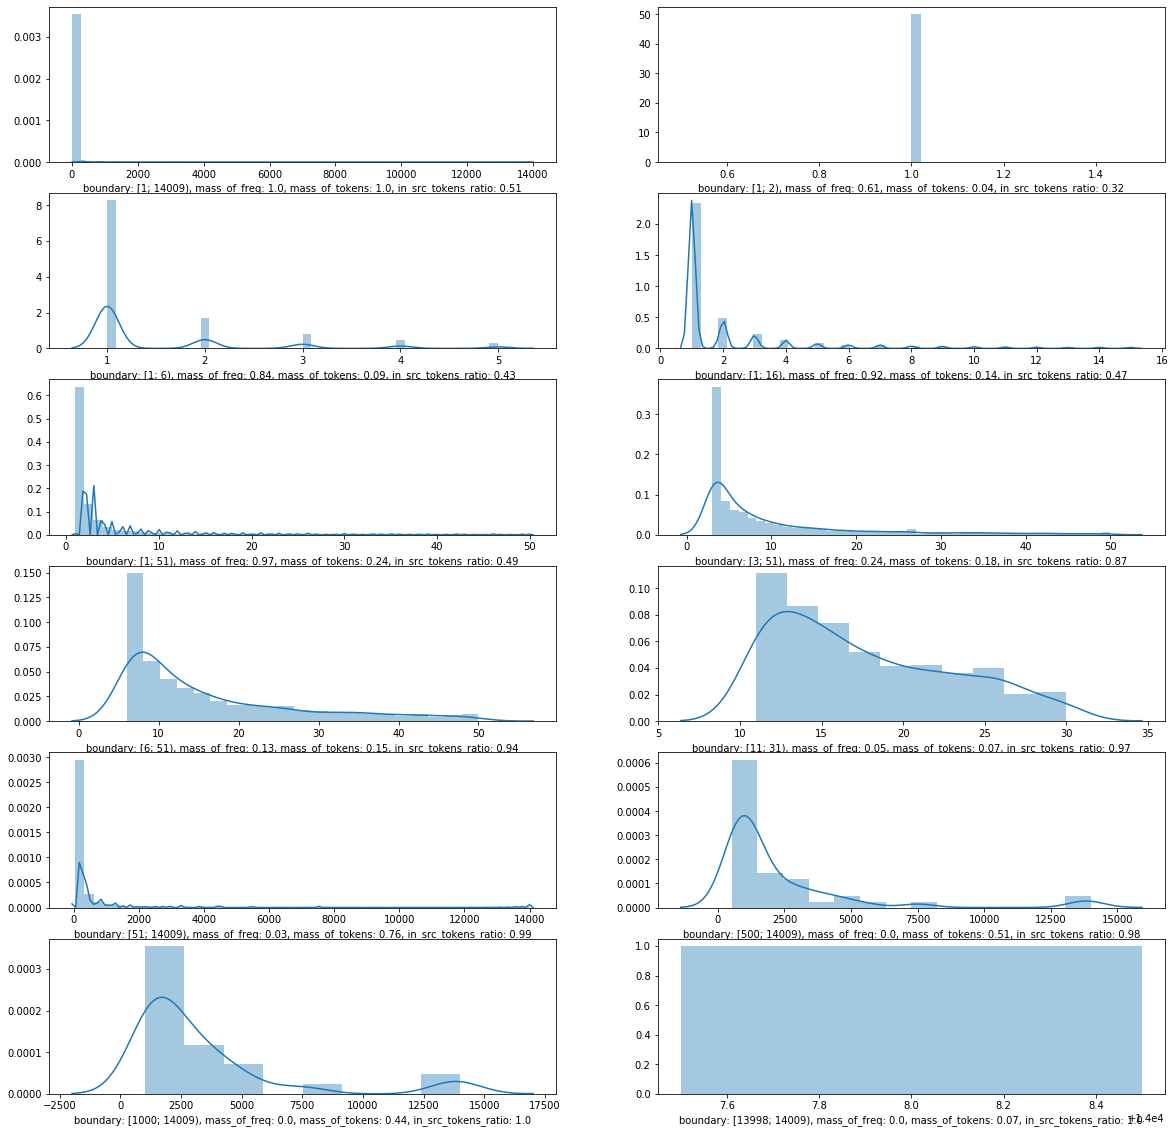


5 examples with frequency in [1; 2) in src
xval
cid
gain
durable
atob
5 examples with frequency in [1; 2) out of src
28610
headlines
23894
30392
travelagent

5 examples with frequency in [500; 14009) in src
web
added
0
"
build
5 examples with frequency in [500; 14009) out of src
lps

5 examples with frequency in [1000; 14009) in src
added
0
.
add
changelog
5 examples with frequency in [1000; 14009) out of src


5 most common words
.    14008
/    13641
-    7514
to    5472
update    4482


In [450]:
analyze_vocabs(ORIGINAL_JIANG_DATA_SRC_VOCAB, ORIGINAL_JIANG_DATA_TRG_VOCAB)

### We can see that most of the tokens (60%) has frequency 1. 97% tokens has frequency up to 50. If we remove tokens with freq <= 50 from vocab we will have 24% of total tokens in sequences as unk tokens and reduce vocab size to 3% (it is 424 examples).
### There is two types of low frequent tokens: copied from src and new. We should check how much are copied. Because we can address this issue with copying mechanism.

### As we see onely 30% of tokens with freq <= 1 can be potentially copied by copying mechanism.  If we leave only tokens with freq > 50 then almost all of them can be copied.

### Let's check that situation for vocab for the whole dataset is the same. Above we've seen only vocab built on train.

In [458]:
ORIGINAL_FULL_JIANG_DATASET_PATH = '../embeddings-for-code-diffs-data/datasets/commit_message_generation/Jiang/full_train'
ORIGINAL_FULL_JIANG_DATA = load_dataset(ORIGINAL_FULL_JIANG_DATASET_PATH)
ORIGINAL_FULL_JIANG_DATA_SRC_VOCAB = ORIGINAL_FULL_JIANG_DATA['train'].fields["src"].vocab
ORIGINAL_FULL_JIANG_DATA_TRG_VOCAB = ORIGINAL_FULL_JIANG_DATA['train'].fields["trg"].vocab

Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 104 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has len

Incorrect example is seen. Error: 0th element of example has length 108 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 105 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 166 > 100
Incorrect example is seen. Error: 0th element of example has length 107 > 100
Incorrect example is seen. Error: 0th element of example has len

Data set sizes (number of sentence pairs):
train 32086
valid 2989
test 2989 

Max src sequence length in tokens: 100
Max trg sequence length in tokens: 30
Max diff sequence length in tokens: 84 

First training example:
src: new file mode 100755 <nl> index 0000000 . . d125c52 <nl> Binary files / dev / null and b / art / intro . png differ <nl>
trg: added intro image .
diff_alignment: удаление удаление удаление удаление удаление
diff_prev: new file mode 100755 <nl>
diff_updated: паддинг паддинг паддинг паддинг паддинг
Most common words in src vocabulary:
         /     278054
      <nl>     265674
         .     155686
         -      95531
         =      57201
         +      41787
         b      31477
         a      31201
         :      28388
       mmm      27156 


Most common words in trg vocabulary:
         .      17230
         /      16870
         -       9256
        to       6721
    update       5527
         '       5458
    ignore       4782
   modules       4134
    

Vocab information
Src size: 73436
Trg size: 16052
Max frequency: 17230
Min frequency: 1
Mean frequency: 15.286141575274177
Std frequency: 242.09462242838373
The most probable frequency: 1, p = 0.61
Number of frequencies (trg_vocab size): 16048
Sum of frequencies (number of tokens in train dataset): 245312


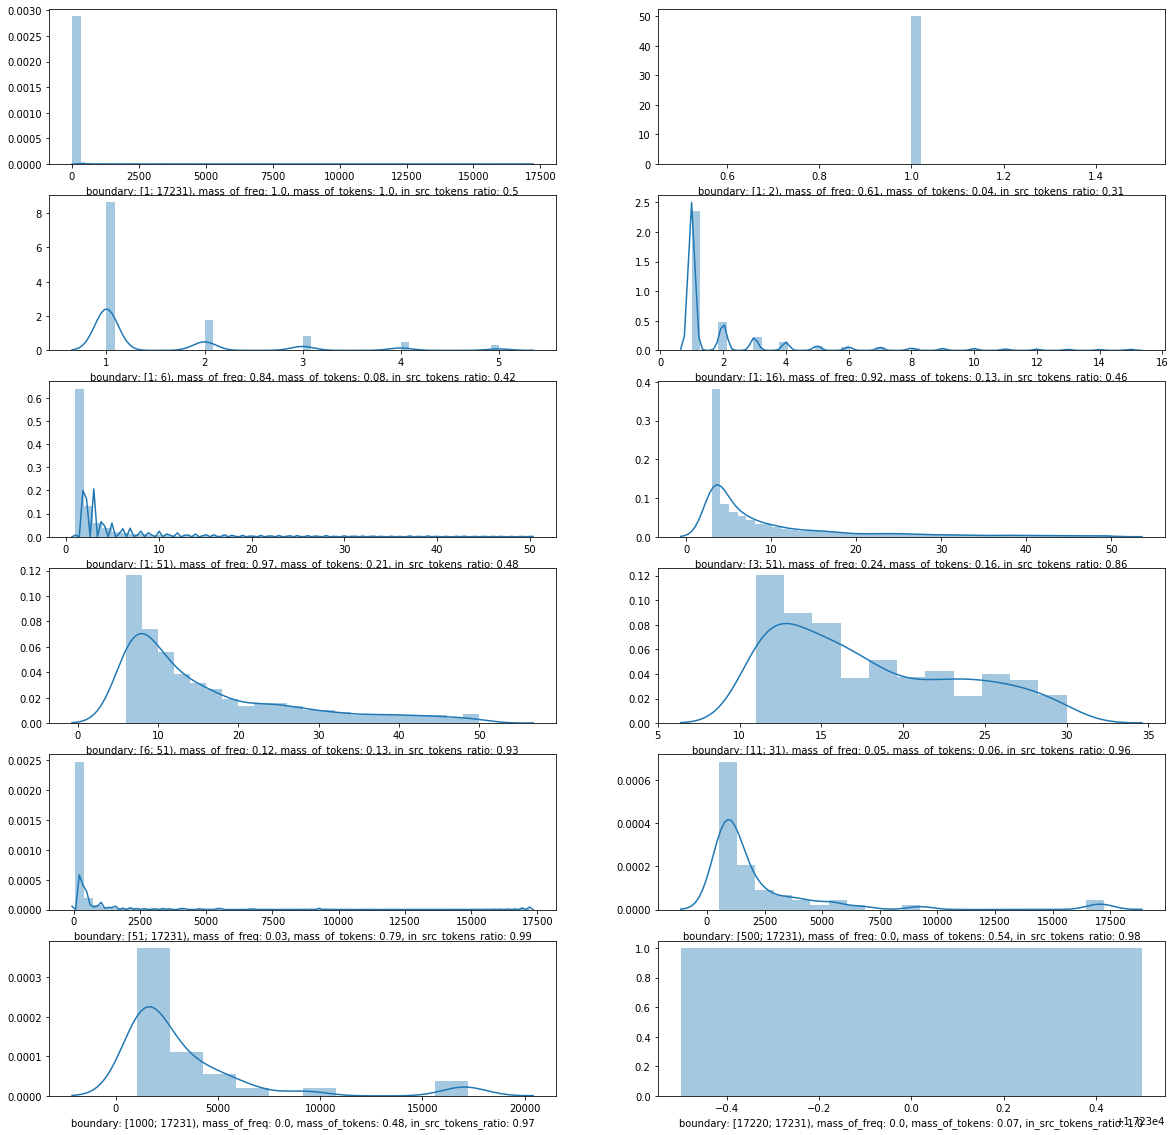


5 examples with frequency in [1; 2) in src
xval
cid
gain
__author__
disposed
5 examples with frequency in [1; 2) out of src
28610
headlines
23894
30392
8703

5 examples with frequency in [500; 17231) in src
web
added
0
"
build
5 examples with frequency in [500; 17231) out of src
lps

5 examples with frequency in [1000; 17231) in src
web
added
0
build
.
5 examples with frequency in [1000; 17231) out of src
lps

5 most common words
.    17230
/    16870
-    9256
to    6721
update    5527


In [459]:
analyze_vocabs(ORIGINAL_FULL_JIANG_DATA_SRC_VOCAB, ORIGINAL_FULL_JIANG_DATA_TRG_VOCAB)

### Same situation therefore in next experiments we will build vocab on train only.

### Now let's take a look at filtered dataset that has only changes (no additions and deletions)

In [395]:
FILTERED_JIANG_DATASET_PATH = '../embeddings-for-code-diffs-data/datasets/commit_message_generation/Jiang/filtered_dataset'
FILTERED_JIANG_DATA = load_dataset(FILTERED_JIANG_DATASET_PATH)
FILTERED_JIANG_DATA_SRC_VOCAB = FILTERED_JIANG_DATA['train'].fields["src"].vocab
FILTERED_JIANG_DATA_TRG_VOCAB = FILTERED_JIANG_DATA['train'].fields["trg"].vocab

Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has len

Data set sizes (number of sentence pairs):
train 20783
valid 2427
test 2318 

Max src sequence length in tokens: 100
Max trg sequence length in tokens: 30
Max diff sequence length in tokens: 84 

First training example:
src: mmm a / telecomm / java / android / telecomm / Connection . java <nl> ppp b / telecomm / java / android / telecomm / Connection . java <nl> public abstract class Connection { <nl> * / <nl> public static String stateToString ( int state ) { <nl> switch ( state ) { <nl> + case State . INITIALIZING : <nl> + return " INITIALIZING " ; <nl> case State . NEW : <nl> return " NEW " ; <nl> case State . RINGING : <nl>
trg: fix wtf when creating a lazily initialized connection
diff_alignment: замена замена добавление добавление добавление добавление добавление добавление добавление добавление добавление добавление добавление добавление
diff_prev: mmm a паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг
diff_updated: ppp b <nl> case 

Vocab information
Src size: 58592
Trg size: 11671
Max frequency: 13442
Min frequency: 1
Mean frequency: 14.12702494214451
Std frequency: 206.02897766420207
The most probable frequency: 1, p = 0.61
Number of frequencies (trg_vocab size): 11667
Sum of frequencies (number of tokens in train dataset): 164820


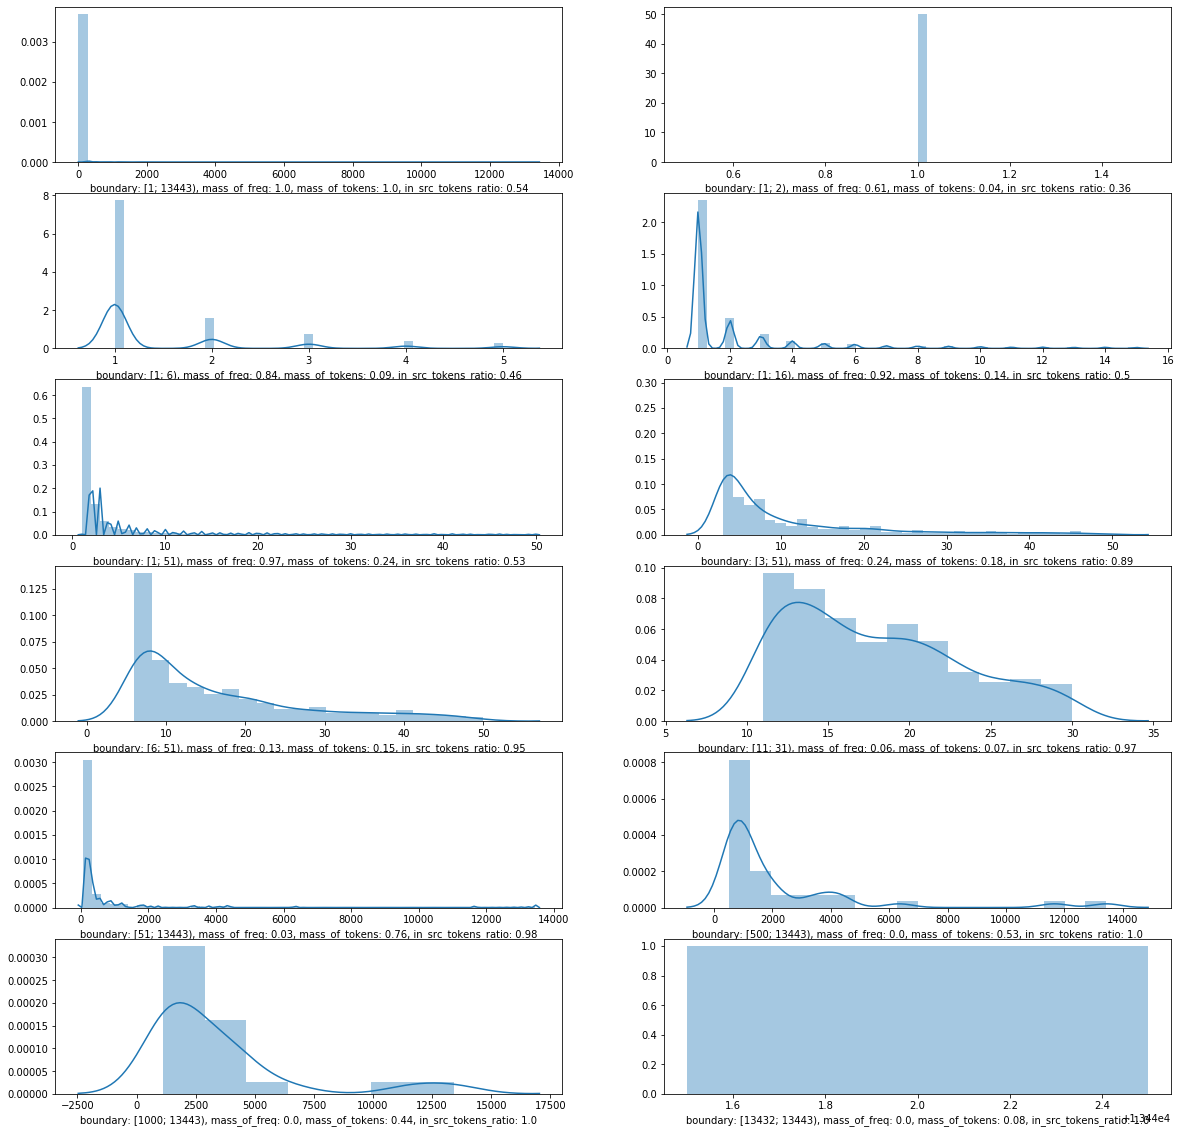


5 examples with frequency in [1; 2) in src
xval
cid
gain
durable
atob
5 examples with frequency in [1; 2) out of src
28610
setstatus
removeoutheader
997
unbounded

5 examples with frequency in [500; 13443) in src
added
web
0
build
"
5 examples with frequency in [500; 13443) out of src


5 examples with frequency in [1000; 13443) in src
added
0
.
add
1
5 examples with frequency in [1000; 13443) out of src


5 most common words
/    13442
.    11656
-    6337
to    4392
'    4310


In [451]:
analyze_vocabs(FILTERED_JIANG_DATA_SRC_VOCAB, FILTERED_JIANG_DATA_TRG_VOCAB)

### Results are pretty the same. Expectable because we filtered not so many examples.

### Now let's take a look at filtered dataset where only java files are changed.

In [397]:
FILTERED_JAVA_JIANG_DATASET_PATH = '../embeddings-for-code-diffs-data/datasets/commit_message_generation/Jiang/filtered_dataset_java_files'
FILTERED_JAVA_JIANG_DATA = load_dataset(FILTERED_JAVA_JIANG_DATASET_PATH)
FILTERED_JAVA_JIANG_DATA_SRC_VOCAB = FILTERED_JAVA_JIANG_DATA['train'].fields["src"].vocab
FILTERED_JAVA_JIANG_DATA_TRG_VOCAB = FILTERED_JAVA_JIANG_DATA['train'].fields["trg"].vocab

Data set sizes (number of sentence pairs):
train 4175
valid 453
test 437 

Max src sequence length in tokens: 99
Max trg sequence length in tokens: 29
Max diff sequence length in tokens: 40 

First training example:
src: mmm a / telecomm / java / android / telecomm / Connection . java <nl> ppp b / telecomm / java / android / telecomm / Connection . java <nl> public abstract class Connection { <nl> * / <nl> public static String stateToString ( int state ) { <nl> switch ( state ) { <nl> + case State . INITIALIZING : <nl> + return " INITIALIZING " ; <nl> case State . NEW : <nl> return " NEW " ; <nl> case State . RINGING : <nl>
trg: fix wtf when creating a lazily initialized connection
diff_alignment: замена замена добавление добавление добавление добавление добавление добавление добавление добавление добавление добавление добавление добавление
diff_prev: mmm a паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг
diff_updated: ppp b <nl> case Stat

### After filtering exclusively java file changes we have 4175 samples, which is 4175 / 26208 = 0.16. This is too small dataset for deep learning.

Vocab information
Src size: 21081
Trg size: 5463
Max frequency: 1380
Min frequency: 1
Mean frequency: 5.483605055871038
Std frequency: 33.36801869561772
The most probable frequency: 1, p = 0.63
Number of frequencies (trg_vocab size): 5459
Sum of frequencies (number of tokens in train dataset): 29935


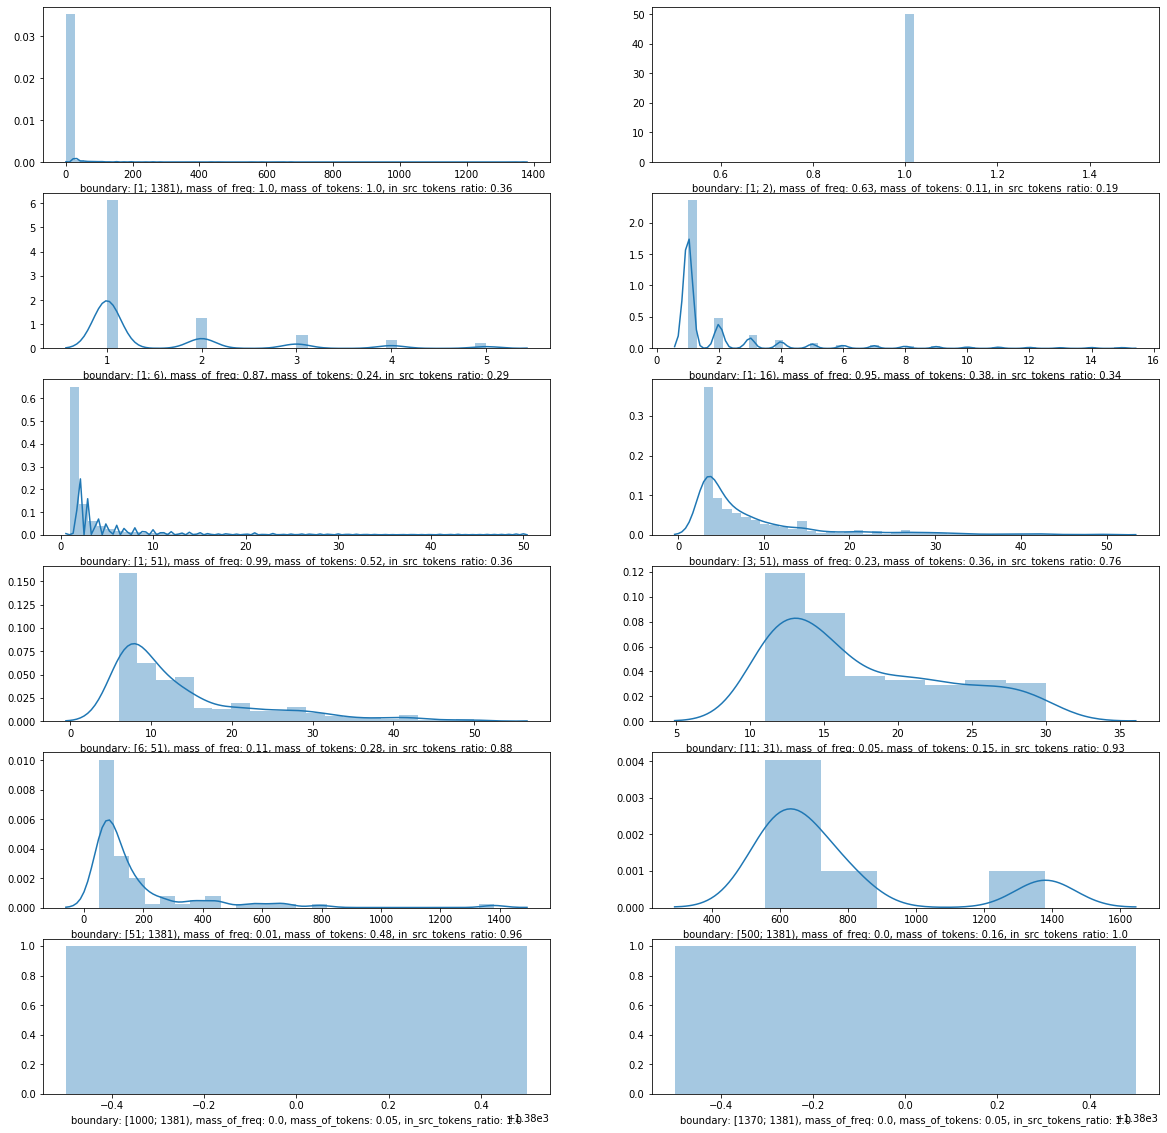


5 examples with frequency in [1; 2) in src
facade
tear
interpreter
defaults
javascript
5 examples with frequency in [1; 2) out of src
cid
setstatus
unbounded
wheelchair
acknowledged

5 examples with frequency in [500; 1381) in src
in
fix
-
the
.
5 examples with frequency in [500; 1381) out of src


5 examples with frequency in [1000; 1381) in src
.
5 examples with frequency in [1000; 1381) out of src


5 most common words
.    1380
fix    795
the    674
to    656
-    586


In [452]:
analyze_vocabs(FILTERED_JAVA_JIANG_DATA_SRC_VOCAB, FILTERED_JAVA_JIANG_DATA_TRG_VOCAB)

### Most frequent is still '.', but frequency is much less 1380, not 14008. But because of the size this filtered version of dataset doesn't suit for us. 

### Now let's take a look what happens if we remove punctuation from commit messages in original Jiang dataset

In [418]:
ORIGINAL_NO_PUNC_JIANG_DATASET_PATH = '../embeddings-for-code-diffs-data/datasets/commit_message_generation/Jiang/full_removed_punctuation'
ORIGINAL_NO_PUNC_JIANG_DATA = load_dataset(ORIGINAL_NO_PUNC_JIANG_DATASET_PATH)
ORIGINAL_NO_PUNC_JIANG_DATA_SRC_VOCAB = ORIGINAL_NO_PUNC_JIANG_DATA['train'].fields["src"].vocab
ORIGINAL_NO_PUNC_JIANG_DATA_TRG_VOCAB = ORIGINAL_NO_PUNC_JIANG_DATA['train'].fields["trg"].vocab

Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 104 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has len

Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 105 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 103 > 100
Incorrect example is seen. Error: 0th element of example has length 105 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 104 > 100
Incorrect example is seen. Error: 0th element of example has length 108 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has len

Data set sizes (number of sentence pairs):
train 26112
valid 2989
test 2989 

Max src sequence length in tokens: 100
Max trg sequence length in tokens: 27
Max diff sequence length in tokens: 84 

First training example:
src: new file mode 100755 <nl> index 0000000 . . d125c52 <nl> Binary files / dev / null and b / art / intro . png differ <nl>
trg: added intro image
diff_alignment: удаление удаление удаление удаление удаление
diff_prev: new file mode 100755 <nl>
diff_updated: паддинг паддинг паддинг паддинг паддинг
Most common words in src vocabulary:
         /     227054
      <nl>     216283
         .     126518
         -      77621
         =      46594
         +      33946
         b      25643
         a      25399
         :      22856
       mmm      22094 


Most common words in trg vocabulary:
        to       5472
    update       4482
    ignore       3873
   modules       3333
      apps       3308
       the       2967
       add       2766
       for       2486
      

Vocab information
Src size: 64982
Trg size: 14129
Max frequency: 5472
Min frequency: 1
Mean frequency: 10.959716814159291
Std frequency: 105.71998951274387
The most probable frequency: 1, p = 0.61
Number of frequencies (trg_vocab size): 14125
Sum of frequencies (number of tokens in train dataset): 154806


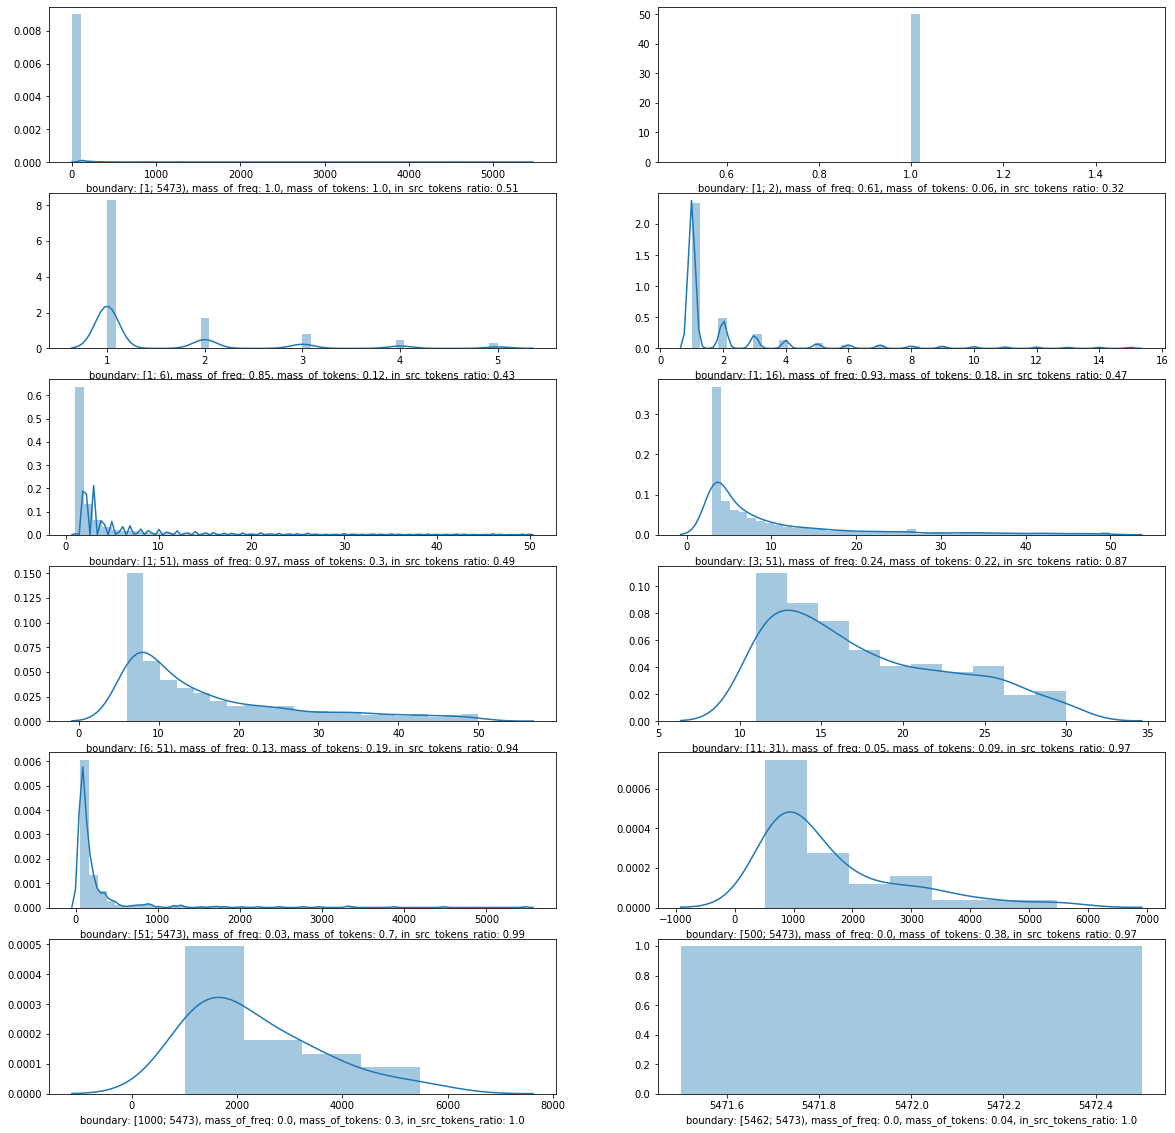


5 examples with frequency in [1; 2) in src
xval
cid
gain
durable
atob
5 examples with frequency in [1; 2) out of src
28610
headlines
23894
30392
travelagent

5 examples with frequency in [500; 5473) in src
web
added
0
build
from
5 examples with frequency in [500; 5473) out of src
lps

5 examples with frequency in [1000; 5473) in src
foundation
in
fix
added
1
5 examples with frequency in [1000; 5473) out of src


5 most common words
to    5472
update    4482
ignore    3873
modules    3333
apps    3308


In [453]:
analyze_vocabs(ORIGINAL_NO_PUNC_JIANG_DATA_SRC_VOCAB, ORIGINAL_NO_PUNC_JIANG_DATA_TRG_VOCAB)

### Nothing changed again. Of course some most common disseapered, but didn't change situation drastically.

### Now let's take a look at what happens if we delete numbers in commit messages too. Numbers are rare tokens.

In [456]:
ORIGINAL_NO_PUNC_NO_NUM_JIANG_DATASET_PATH = '../embeddings-for-code-diffs-data/datasets/commit_message_generation/Jiang/full_removed_punctuation_removed_numbers'
ORIGINAL_NO_PUNC_NO_NUM_JIANG_DATA = load_dataset(ORIGINAL_NO_PUNC_NO_NUM_JIANG_DATASET_PATH)
ORIGINAL_NO_PUNC_NO_NUM_JIANG_DATA_SRC_VOCAB = ORIGINAL_NO_PUNC_NO_NUM_JIANG_DATA['train'].fields["src"].vocab
ORIGINAL_NO_PUNC_NO_NUM_JIANG_DATA_TRG_VOCAB = ORIGINAL_NO_PUNC_NO_NUM_JIANG_DATA['train'].fields["trg"].vocab

Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 104 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has len

Incorrect example is seen. Error: 0th element of example has length 103 > 100
Incorrect example is seen. Error: 0th element of example has length 105 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 104 > 100
Incorrect example is seen. Error: 0th element of example has length 108 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 103 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 112 > 100
Incorrect example is seen. Error: 0th element of example has length 107 > 100
Incorrect example is seen. Error: 0th element of example has length 104 > 100
Incorrect example is seen. Error: 0th element of example has length 106 > 100
Incorrect example is seen. Error: 0th element of example has len

Data set sizes (number of sentence pairs):
train 26112
valid 2989
test 2989 

Max src sequence length in tokens: 100
Max trg sequence length in tokens: 27
Max diff sequence length in tokens: 84 

First training example:
src: new file mode 100755 <nl> index 0000000 . . d125c52 <nl> Binary files / dev / null and b / art / intro . png differ <nl>
trg: added intro image
diff_alignment: удаление удаление удаление удаление удаление
diff_prev: new file mode 100755 <nl>
diff_updated: паддинг паддинг паддинг паддинг паддинг
Most common words in src vocabulary:
         /     227054
      <nl>     216283
         .     126518
         -      77621
         =      46594
         +      33946
         b      25643
         a      25399
         :      22856
       mmm      22094 


Most common words in trg vocabulary:
        to       5472
    update       4482
    ignore       3873
   modules       3333
      apps       3308
       the       2967
       add       2766
       for       2486
      

Vocab information
Src size: 64982
Trg size: 11946
Max frequency: 5472
Min frequency: 1
Mean frequency: 12.273823480154078
Std frequency: 113.37493306620233
The most probable frequency: 1, p = 0.57
Number of frequencies (trg_vocab size): 11942
Sum of frequencies (number of tokens in train dataset): 146574


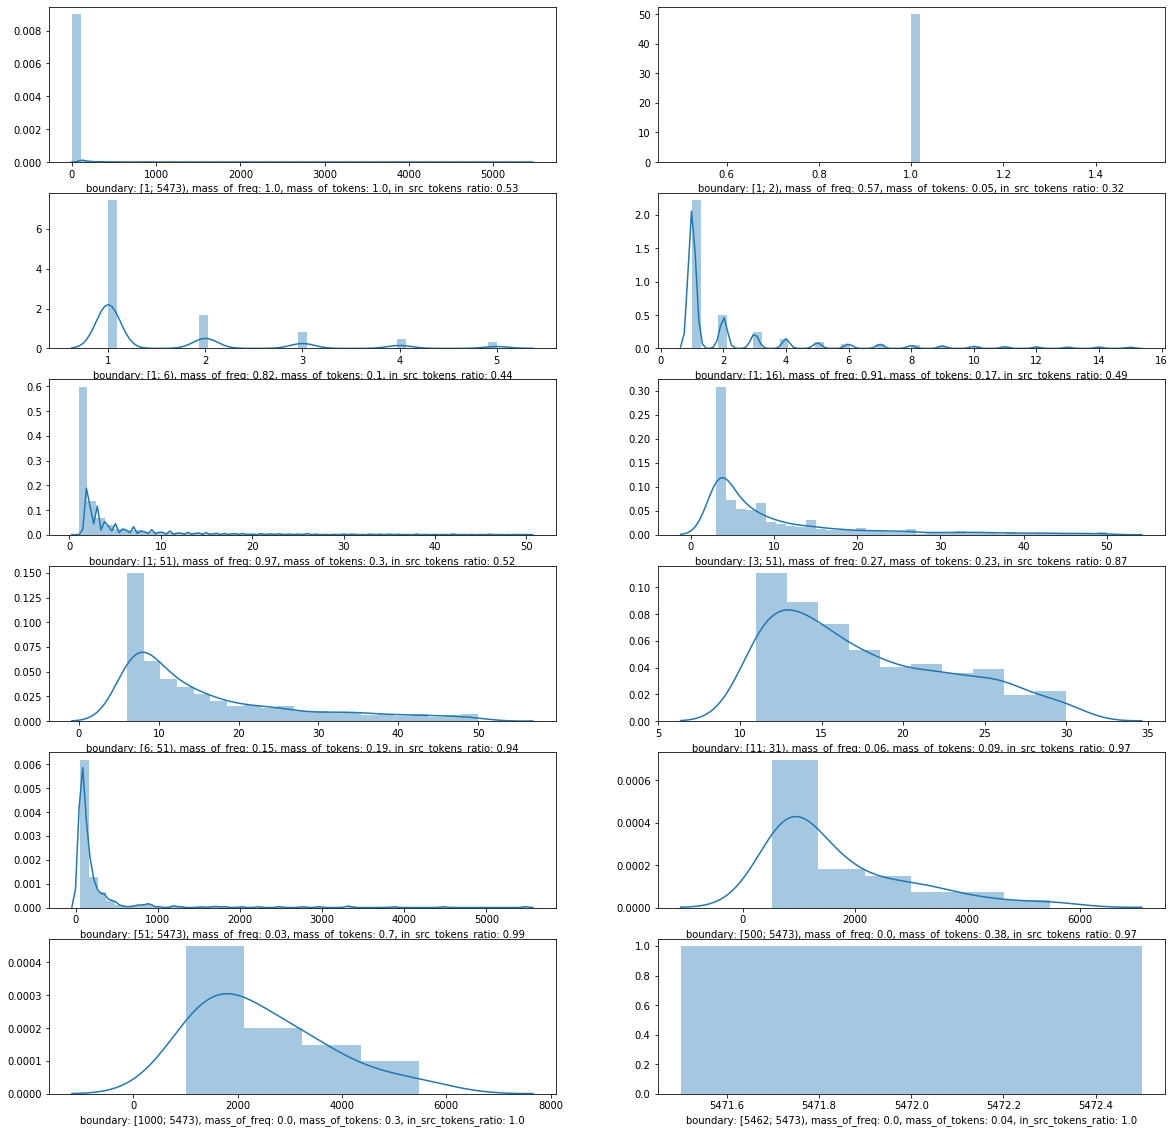


5 examples with frequency in [1; 2) in src
xval
cid
gain
durable
atob
5 examples with frequency in [1; 2) out of src
setstatus
noc
removeoutheader
unbounded
headlines

5 examples with frequency in [500; 5473) in src
added
web
build
from
add
5 examples with frequency in [500; 5473) out of src
lps

5 examples with frequency in [1000; 5473) in src
foundation
in
fix
added
version
5 examples with frequency in [1000; 5473) out of src


5 most common words
to    5472
update    4482
ignore    3873
modules    3333
apps    3308


In [457]:
analyze_vocabs(ORIGINAL_NO_PUNC_NO_NUM_JIANG_DATA_SRC_VOCAB, ORIGINAL_NO_PUNC_NO_NUM_JIANG_DATA_TRG_VOCAB)

### Nothing changed

In [427]:
def load_dataset_neural_editor(dataset_path: str):
    config = {
        'TOKEN_MIN_FREQ': 1,
        'TOKENS_CODE_CHUNK_MAX_LEN': 100,
        'MSG_MAX_LEN': 30,
        'DATASET_ROOT': dataset_path,
        'DATASET_ROOT_COMMIT': dataset_path,
        'LOWER': False,
        'LOWER_COMMIT_MSG': True,
        'UNK_TOKEN': "<unk>",
        'PAD_TOKEN': "<pad>",
        'SOS_TOKEN': "<s>",
        'EOS_TOKEN': "</s>",
        'REPLACEMENT_TOKEN': 'замена',
        'DELETION_TOKEN': 'удаление',
        'ADDITION_TOKEN': 'добавление',
        'UNCHANGED_TOKEN': 'равенство',
        'PADDING_TOKEN': 'паддинг',
        'LEAVE_ONLY_CHANGED': True,
    }
    train_dataset, val_dataset, test_dataset, diffs_field = \
        CodeChangesTokensDataset.load_data(True, config)
    data = {'train': train_dataset, 'validation': val_dataset, 'test': test_dataset}
    return data, diffs_field

### Now let's take a look at neural editor distribution (it is almost src for cmg model)

In [428]:
NE_ORIGINAL_JIANG_DATASET_PATH = '../embeddings-for-code-diffs-data/datasets/commit_message_generation/Jiang/full'
NE_ORIGINAL_JIANG_DATA, NE_ORIGINAL_JIANG_DIFFS_FIELD = load_dataset_neural_editor(NE_ORIGINAL_JIANG_DATASET_PATH)
NE_ORIGINAL_JIANG_DATA_SRC_VOCAB = NE_ORIGINAL_JIANG_DATA['train'].fields["src"].vocab
NE_ORIGINAL_JIANG_DATA_TRG_VOCAB = NE_ORIGINAL_JIANG_DATA['train'].fields["trg"].vocab

Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has length 104 > 100
Incorrect example is seen. Error: 0th element of example has length 101 > 100
Incorrect example is seen. Error: 0th element of example has length 102 > 100
Incorrect example is seen. Error: 0th element of example has len

Data set sizes (number of sentence pairs):
train 26195
valid 2998
test 2999 

Max sequence length in tokens: 99 

First training example:
src: new file mode 100755 <nl> Binary files / dev / null and b / art / intro . png differ <nl>
trg: Binary files / dev / null and b / art / intro . png differ <nl>
diff_alignment: удаление удаление удаление удаление удаление
diff_prev: new file mode 100755 <nl>
diff_updated: паддинг паддинг паддинг паддинг паддинг 

Most common words:
      <nl>     345324
         /     291588
         .     181652
   паддинг     174040
добавление     118759
         -      90098
    замена      75574
         =      74616
  удаление      55281
         b      51554 

First 10 words:
00 <unk>
01 <pad>
02 <s>
03 </s>
04 <nl>
05 /
06 .
07 паддинг
08 добавление
09 - 

Special words frequency and ids: 
<unk> 0 0
<pad> 0 1
<s> 0 2
</s> 0 3
замена 75574 10
удаление 55281 12
добавление 118759 8
равенство 0 0
паддинг 174040 7
Number of words (types): 62335


Vocab information
Src size: 62335
Trg size: 62335
Max frequency: 345324
Min frequency: 2
Mean frequency: 53.737867192889574
Std frequency: 2308.6998569410875
The most probable frequency: 2, p = 0.52
Number of frequencies (trg_vocab size): 62331
Sum of frequencies (number of tokens in train dataset): 3349535


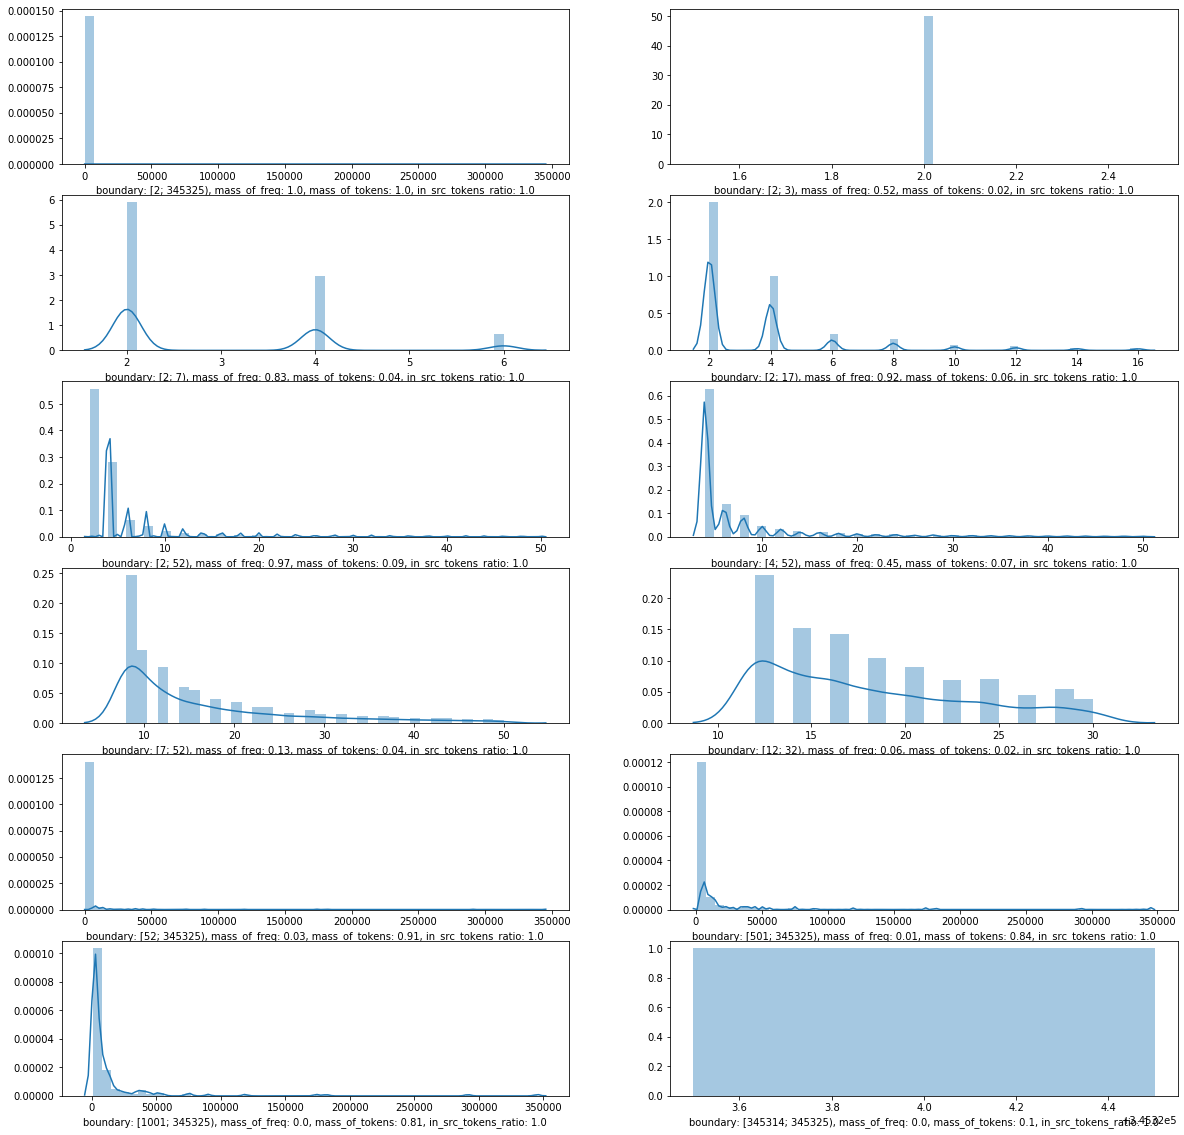


5 examples with frequency in [2; 3) in src
TextCheckerCGI
open_w
overriden
tileEntityRenderer
spinor
5 examples with frequency in [2; 3) out of src


5 examples with frequency in [501; 345325) in src
14
final
web
html
"
5 examples with frequency in [501; 345325) out of src


5 examples with frequency in [1001; 345325) in src
final
web
html
build
"
5 examples with frequency in [1001; 345325) out of src


5 most common words
<nl>    345324
/    291588
.    181652
паддинг    174040
добавление    118759


In [454]:
analyze_vocabs(NE_ORIGINAL_JIANG_DATA_SRC_VOCAB, NE_ORIGINAL_JIANG_DATA_TRG_VOCAB)

In [438]:
NE_CODE_CHANGES_TUFANO_DATASET_PATH = '../embeddings-for-code-diffs-data/datasets/java/tufano_code_changes/0_50'
NE_CODE_CHANGES_TUFANO_DATA, NE_CODE_CHANGES_TUFANO_DIFFS_FIELD = load_dataset_neural_editor(NE_CODE_CHANGES_TUFANO_DATASET_PATH)
NE_CODE_CHANGES_TUFANO_DATA_SRC_VOCAB = NE_CODE_CHANGES_TUFANO_DATA['train'].fields["src"].vocab
NE_CODE_CHANGES_TUFANO_DATA_TRG_VOCAB = NE_CODE_CHANGES_TUFANO_DATA['train'].fields["trg"].vocab

Data set sizes (number of sentence pairs):
train 8627
valid 1079
test 1077 

Max sequence length in tokens: 50 

First training example:
src: private void METHOD_1 ( ) { VAR_1 . METHOD_2 ( STRING_1 , VAR_2 , VAR_3 ) ; TYPE_1 . METHOD_1 ( ( VAR_2 ? VAR_3 : 0 ) ) ; }
trg: private void METHOD_1 ( ) { TYPE_1 . METHOD_1 ( ( VAR_2 ? VAR_3 : 0 ) ) ; }
diff_alignment: удаление удаление удаление удаление удаление удаление удаление удаление удаление удаление удаление
diff_prev: VAR_1 . METHOD_2 ( STRING_1 , VAR_2 , VAR_3 ) ;
diff_updated: паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг паддинг 

Most common words:
         (      76236
         )      76208
   паддинг      44322
  удаление      34492
         ;      33724
         .      30504
     VAR_1      24100
         ,      23668
         {      22776
         }      22616 

First 10 words:
00 <unk>
01 <pad>
02 <s>
03 </s>
04 (
05 )
06 паддинг
07 удаление
08 ;
09 . 

Special words frequency and ids: 
<unk> 

Vocab information
Src size: 662
Trg size: 662
Max frequency: 76236
Min frequency: 2
Mean frequency: 1015.9042553191489
Std frequency: 5539.922690331076
The most probable frequency: 2, p = 0.06
Number of frequencies (trg_vocab size): 658
Sum of frequencies (number of tokens in train dataset): 668465


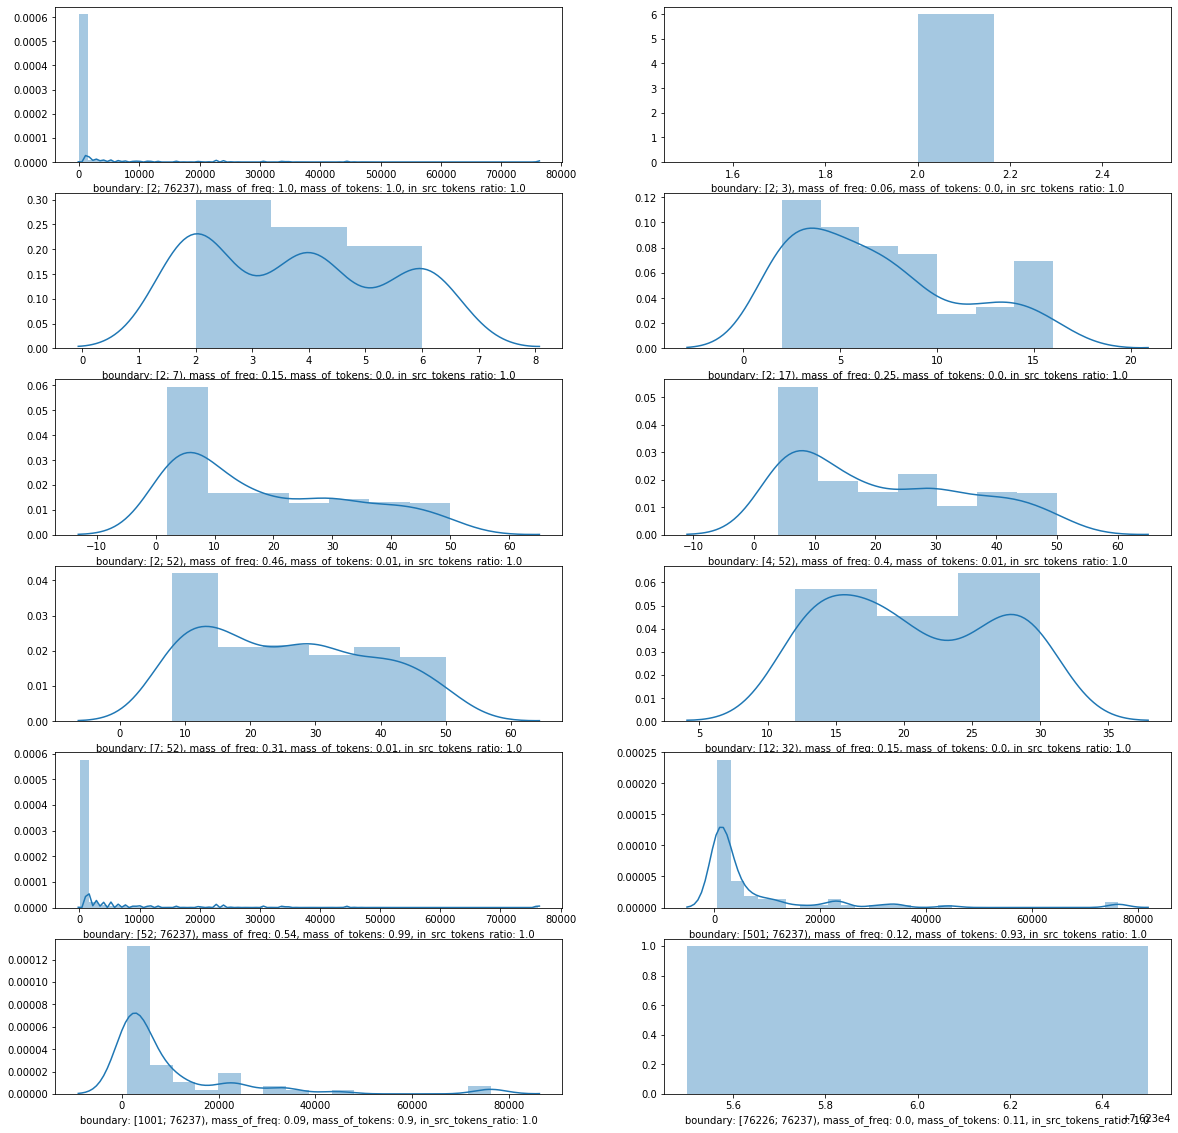


5 examples with frequency in [2; 3) in src
AuditLogDirector
*=
sshd
frontend
org.ovirt.engine.ui.frontend.INewAsyncCallback
5 examples with frequency in [2; 3) out of src


5 examples with frequency in [501; 76237) in src
final
STRING_1
null
;
false
5 examples with frequency in [501; 76237) out of src


5 examples with frequency in [1001; 76237) in src
final
STRING_1
null
;
false
5 examples with frequency in [1001; 76237) out of src


5 most common words
(    76236
)    76208
паддинг    44322
удаление    34492
;    33724


In [455]:
analyze_vocabs(NE_CODE_CHANGES_TUFANO_DATA_SRC_VOCAB, NE_CODE_CHANGES_TUFANO_DATA_TRG_VOCAB)